In [1]:
# horse-or-human classification model with CNN
# train : 1027 images [horse(500) + human(527)] , 300*300 pixels
# validation : 256 images [horse(128) + human(128)] , 300*300 pixels

In [1]:
import tensorflow as tf
import urllib
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

tf.__version__

'2.17.0'

In [3]:
# Colab용 : Linux/GPU사용
# !wget --no-check-certificate \
#     https://storage.googleapis.com/download.tensorflow.org/data/horse-or-human.zip \
#     -O /tmp/horse-or-human.zip

# !wget --no-check-certificate \
#    https://storage.googleapis.com/download.tensorflow.org/data/validation-horse-or-human.zip\
#     -O /tmp/validation-horse-or-human.zip

In [2]:
# horse-or-human 데이터셋 다운로드 , Windows용
_TRAIN_URL = "https://storage.googleapis.com/download.tensorflow.org/data/horse-or-human.zip"
_TEST_URL = "https://storage.googleapis.com/download.tensorflow.org/data/validation-horse-or-human.zip"
urllib.request.urlretrieve(_TRAIN_URL, 'horse-or-human.zip')
urllib.request.urlretrieve(_TEST_URL, 'validation-horse-or-human.zip')

('validation-horse-or-human.zip', <http.client.HTTPMessage at 0x1b9518047c0>)

In [3]:
# 압축해제
local_zip = 'horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/horse-or-human/')
zip_ref.close()
local_zip = 'validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/validation-horse-or-human/')
zip_ref.close()

train_dir = 'tmp/horse-or-human'
validation_dir = 'tmp/validation-horse-or-human'

In [4]:
# 이미지 데이터 경로 설정
import os
# Directory with our training horse pictures
train_horse_dir = os.path.join('tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('tmp/horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('tmp/validation-horse-or-human/horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('tmp/validation-horse-or-human/humans')

train_horse_names = os.listdir(train_horse_dir)
# print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
# print(train_human_names[:10])

validation_horse_names = os.listdir(validation_horse_dir)
# print(validation_horse_names[:10])

validation_human_names = os.listdir(validation_human_dir)

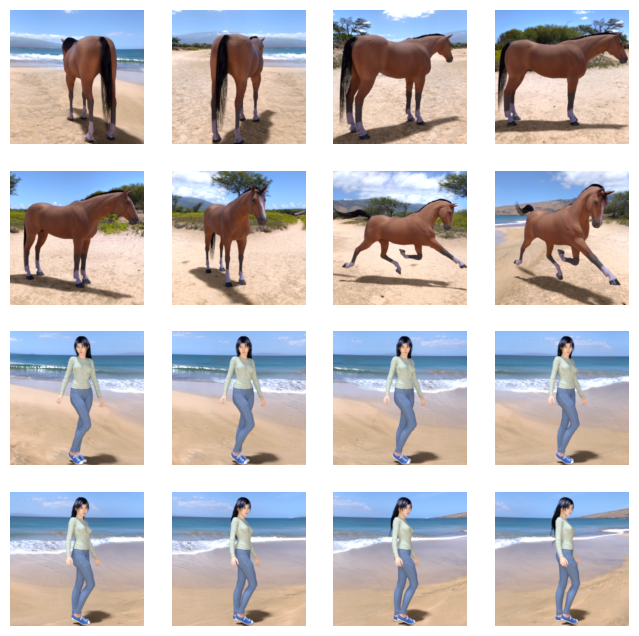

In [5]:
# 데이터 시각화 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 15  # 시작 인덱스

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*2, nrows*2)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

# print(next_horse_pix)
# print(next_human_pix)

for i, img_path in enumerate(next_horse_pix+next_human_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

### 데이터 전처리 : 이미지 증강(Image Augmentation)

In [8]:
# !pip install Augmentor
import Augmentor

# 증강 시킬 이미지 폴더 경로
img = Augmentor.Pipeline("augmentation_test/")

# 좌우 반전
img.flip_left_right(probability=1.0)

# 상하 반전
img.flip_top_bottom(probability=1.0)

# 왜곡
img. random_distortion(probability=1,grid_width=10,grid_height=10,magnitude=8)

# 증강 이미지수
img. sample(10)

Initialised with 1 image(s) found.
Output directory set to augmentation_test/output.

Processing <PIL.Image.Image image mode=RGBA size=257x252 at 0x26CD7FBA2C0>: 100%|█| 10/10 [00:00<00:00, 29.39 Samples/s


In [9]:
## CNN 모델 구현
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(300, 300, 3)),
    tf.keras.layers.Conv2D(16,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),   

    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),   

    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')    
])

model.compile(optimizer = RMSprop(learning_rate=0.001),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 298, 298, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 149, 149, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 147, 147, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 73, 73, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 71, 71, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 35, 35, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 33, 33, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,606,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,704,097 (6.50 MB)

 Trainable params: 1,704,097 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# map() 함수
def add_two(x):
    print('add_two is called!')
    return 2 + x

print(add_two(10))

m = map(add_two,[1,2,3,4,5])
print(m)
# print(list(m))

add_two is called!
12


In [11]:
# dir(m)   # '__next__'
# next(m)  # Generator
# for k in m:
#     print(k)
#     input()

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255.)
# print(train_datagen)

validation_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(
        train_dir,  # 'tmp/horse-or-human/'
        target_size = (300,300),  # resize 될 크기
        batch_size = 128,
        class_mode = 'binary')    

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,  # 'tmp/validation-horse-or-human'
        target_size = (300,300),  # resize 될 크기
        batch_size = 32,
        class_mode = 'binary')

print(train_generator) # DirectoryIterator object , 실제 사용 시점(학습시)에 데이터 생성
# fit 호출시 1 epoch 마다 train 이미지 1027개 생성  : 15 epochs 일 경우 총 15*1027 증강 이미지 생성
# fit 호출시 1 epoch 마다 validation 이미지 256개 생성  : 15 epochs 일 경우 총 15*256 증강 이미지 생성

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [13]:
# 학습
history = model.fit(train_generator,     # x_train
                    steps_per_epoch=8,   # 1027/128 
                    epochs = 15,
                    verbose = 1,
                    validation_data=validation_generator)

Epoch 1/15


C:\Users\storm\anaconda3\envs\tf217\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.4894 - loss: 0.7428 - val_accuracy: 0.6445 - val_loss: 0.6829
Epoch 2/15
1/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8203 - loss: 0.6836

C:\Users\storm\anaconda3\envs\tf217\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - accuracy: 0.8203 - loss: 0.6836 - val_accuracy: 0.5000 - val_loss: 0.7145
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5911 - loss: 0.7204 - val_accuracy: 0.5000 - val_loss: 0.6795
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.3333 - loss: 0.6971 - val_accuracy: 0.8867 - val_loss: 0.6785
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6496 - loss: 0.6760 - val_accuracy: 0.5156 - val_loss: 0.6502
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 327ms/step - accuracy: 0.5703 - loss: 0.6615 - val_accuracy: 0.5195 - val_loss: 0.6379
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.6887 - loss: 0.6819 - val_accuracy: 0.5000 - val_loss: 0.6712
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 258ms/step - accuracy: 0.6641 - loss: 0.5800 - val_accuracy: 0.5000 - val_loss: 0.8233
Epoch 9/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.7030 - loss: 0.5719 - val_accuracy: 0.8281 - val_loss: 0.4371
Epoch 10/15

### 학습 결과 시각화

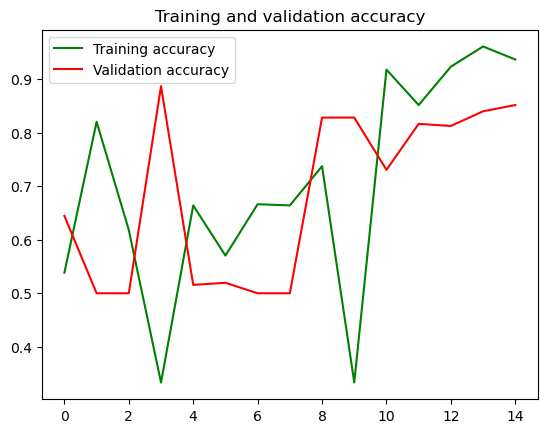

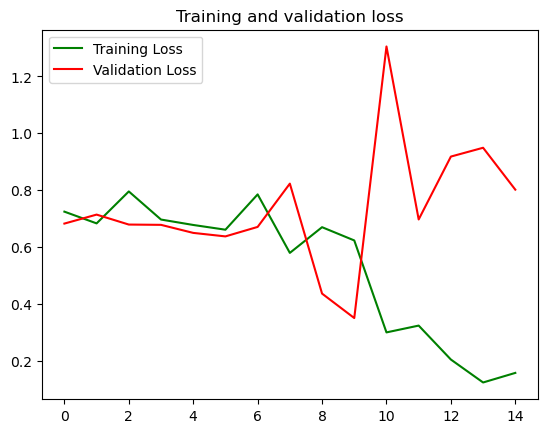

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
# 예측
import numpy as np
from tensorflow.keras.preprocessing import image

def image_predict(file_name):
    path = 'horse-or-human예측용이미지/' + file_name
    img = image.load_img(path, target_size=(300, 300))
    x = image.img_to_array(img)   # 2차원 ndarray로 변환
    x = np.expand_dims(x, axis=0) # 3차원으로 변환
    images = np.vstack([x])       # 4차원으로 변환
    classes = model.predict(images, batch_size=10)
    # print(classes[0],end=' ')
    if classes[0] == 1.0:
        print(file_name ,': human')
    else:
        print(file_name ,': horse')
image_predict('말01.jpg')        
image_predict('말02.jpg') 
image_predict('기린.jpg')    
image_predict('말과사람.jpg')
image_predict('말과사람02.jpg')
image_predict('말과사람06.jpg')
image_predict('사람01.jpg')
image_predict('사람02.jpg')
image_predict('사람12.jpg')
image_predict('말타기게임하는사람.jpg')        

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
말01.jpg : horse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
말02.jpg : horse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
기린.jpg : horse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
말과사람.jpg : horse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
말과사람02.jpg : human
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
말과사람06.jpg : human
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
사람01.jpg : horse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
사람02.jpg : human
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
사람12.jpg : horse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
말타기게임하는사람.jpg : horse


In [6]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get('accuracy') > 0.999):
                print("\nReached 99.9% accuracy so cancelling training!")
                self.model.stop_training = True

callbacks = myCallback()

In [13]:
# ! mkdir tmp\saved_train_image
# ! mkdir tmp\saved_val_image

In [17]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                               rotation_range = 40,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                        batch_size = 20,
                                        class_mode = 'binary',
                                        # save_to_dir =  'tmp/saved_train_image',          
                                        target_size = (300, 300))
    

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                      batch_size  = 20,
                                      class_mode  = 'binary',
                                      # save_to_dir =  'tmp/saved_val_image',                            
                                      target_size = (300, 300))

Found 1028 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

# CPU버전:약 15분 소요 ,epochs=10  , GPU: 약 4분
model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=50,  # 1027/20
    # epochs = 100,
    epochs=10,
    validation_steps=12,  # 256/20
    verbose=1,
    callbacks=[callbacks])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 298, 298, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 149, 149, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 147, 147, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 73, 73, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 71, 71, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 35, 35, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 78400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │      40,141,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,165,409 (153.22 MB)

 Trainable params: 40,165,409 (153.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5854 - loss: 2.7925 - val_accuracy: 0.4875 - val_loss: 1.3780
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7725 - loss: 0.5352 - val_accuracy: 0.7500 - val_loss: 0.6280
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7088 - loss: 0.5742 - val_accuracy: 0.5125 - val_loss: 1.4767
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6990 - loss: 0.4681 - val_accuracy: 0.6250 - val_loss: 1.1103
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7580 - loss: 0.4962 - val_accuracy: 0.6083 - val_loss: 1.2898
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7990 - loss: 0.4608 - val_accuracy: 0.3750 - val_loss: 2.6418
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8209 - loss: 0.4071 - val_accuracy: 0.5167 - val_loss: 2.7265
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8990 - loss: 0.2462 - val_accuracy: 0.5000 - val_l